# Student Dropout Predictor

## Preparing the data

In [26]:
%pip install ucimlrepo matplotlib numpy pandas scikit-learn scikeras tensorflow seaborn xgboost

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697) 
  
# data (as pandas dataframes) 
X = predict_students_dropout_and_academic_success.data.features 
y = predict_students_dropout_and_academic_success.data.targets 
  
# metadata 
print(predict_students_dropout_and_academic_success.metadata) 
  
# variable information 
print(predict_students_dropout_and_academic_success.variables) 


{'uci_id': 697, 'name': "Predict Students' Dropout and Academic Success", 'repository_url': 'https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success', 'data_url': 'https://archive.ics.uci.edu/static/public/697/data.csv', 'abstract': "A dataset created from a higher education institution (acquired from several disjoint databases) related to students enrolled in different undergraduate degrees, such as agronomy, design, education, nursing, journalism, management, social service, and technologies.\nThe dataset includes information known at the time of student enrollment (academic path, demographics, and social-economic factors) and the students' academic performance at the end of the first and second semesters. \nThe data is used to build classification models to predict students' dropout and academic sucess. The problem is formulated as a three category classification task, in which there is a strong imbalance towards one of the classes.", 'area': 'Social Sc

In [6]:
features_df = pd.DataFrame(X)
target_df = pd.DataFrame(y)
print(features_df.describe())
print(target_df.describe())

       Marital Status  Application mode  Application order       Course  \
count     4424.000000       4424.000000        4424.000000  4424.000000   
mean         1.178571         18.669078           1.727848  8856.642631   
std          0.605747         17.484682           1.313793  2063.566416   
min          1.000000          1.000000           0.000000    33.000000   
25%          1.000000          1.000000           1.000000  9085.000000   
50%          1.000000         17.000000           1.000000  9238.000000   
75%          1.000000         39.000000           2.000000  9556.000000   
max          6.000000         57.000000           9.000000  9991.000000   

       Daytime/evening attendance  Previous qualification  \
count                 4424.000000             4424.000000   
mean                     0.890823                4.577758   
std                      0.311897               10.216592   
min                      0.000000                1.000000   
25%                

In [7]:
# remove spaces from the column names and convert to lowercase
features_df.columns = features_df.columns.str.replace(' ', '_')
features_df.columns = features_df.columns.str.lower()
target_df.columns = target_df.columns.str.lower()
print(features_df.columns)


Index(['marital_status', 'application_mode', 'application_order', 'course',
       'daytime/evening_attendance', 'previous_qualification',
       'previous_qualification_(grade)', 'nacionality',
       'mother's_qualification', 'father's_qualification',
       'mother's_occupation', 'father's_occupation', 'admission_grade',
       'displaced', 'educational_special_needs', 'debtor',
       'tuition_fees_up_to_date', 'gender', 'scholarship_holder',
       'age_at_enrollment', 'international',
       'curricular_units_1st_sem_(credited)',
       'curricular_units_1st_sem_(enrolled)',
       'curricular_units_1st_sem_(evaluations)',
       'curricular_units_1st_sem_(approved)',
       'curricular_units_1st_sem_(grade)',
       'curricular_units_1st_sem_(without_evaluations)',
       'curricular_units_2nd_sem_(credited)',
       'curricular_units_2nd_sem_(enrolled)',
       'curricular_units_2nd_sem_(evaluations)',
       'curricular_units_2nd_sem_(approved)',
       'curricular_units_2nd_s

In [8]:
print(target_df["target"].unique())

# replace Dropout, Graduate and Enrolled with 0, 1 and 2 respectively
target_df["target"] = target_df["target"].replace({"Dropout": 0, "Graduate": 1, "Enrolled": 2})

print(target_df["target"].unique())

['Dropout' 'Graduate' 'Enrolled']
[0 1 2]


/var/folders/05/9zyb9k_948z_p4nckqd890640000gn/T/ipykernel_21752/1756288879.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target_df["target"] = target_df["target"].replace({"Dropout": 0, "Graduate": 1, "Enrolled": 2})


In [9]:
# Defining the the different types of columns

binary_columns = ["daytime/evening_attendance", "international", "displaced", "educational_special_needs", 
                  "debtor", "tuition_fees_up_to_date", "gender", "scholarship_holder"]

multi_class_columns = ["marital_status", "application_mode", "application_order", "course", "nacionality"]

ordinal_columns = ["previous_qualification", "mother's_qualification", "father's_qualification", 
                   "mother's_occupation", "father's_occupation"]

numerical_columns = [col for col in features_df.columns if col not in binary_columns + multi_class_columns + ordinal_columns]

print(len(binary_columns) + len(multi_class_columns) + len(ordinal_columns) + len(numerical_columns))

36


### Preparing the mapping for the multi-class columns

In [10]:
# Mapping for marital status
marital_status_map = {
    1: "single",
    2: "married",
    3: "widower",
    4: "divorced",
    5: "facto union",
    6: "legally separated"
}

# Mapping for admission process
application_mode_map = {
    1: "1st phase - general contingent",
    2: "Ordinance No. 612/93",
    5: "1st phase - special contingent (Azores Island)",
    7: "Holders of other higher courses",
    10: "Ordinance No. 854-B/99",
    15: "International student (bachelor)",
    16: "1st phase - special contingent (Madeira Island)",
    17: "2nd phase - general contingent",
    18: "3rd phase - general contingent",
    26: "Ordinance No. 533-A/99, item b2) (Different Plan)",
    27: "Ordinance No. 533-A/99, item b3 (Other Institution)",
    39: "Over 23 years old",
    42: "Transfer",
    43: "Change of course",
    44: "Technological specialization diploma holders",
    51: "Change of institution/course",
    53: "Short cycle diploma holders",
    57: "Change of institution/course (International)"
}

# Mapping for course/program names
course_map = {
    33: "Biofuel Production Technologies",
    171: "Animation and Multimedia Design",
    8014: "Social Service (evening attendance)",
    9003: "Agronomy",
    9070: "Communication Design",
    9085: "Veterinary Nursing",
    9119: "Informatics Engineering",
    9130: "Equinculture",
    9147: "Management",
    9238: "Social Service",
    9254: "Tourism",
    9500: "Nursing",
    9556: "Oral Hygiene",
    9670: "Advertising and Marketing Management",
    9773: "Journalism and Communication",
    9853: "Basic Education",
    9991: "Management (evening attendance)"
}

# Mapping for education levels
previous_qualification_map = {
    1: "Secondary education",
    2: "Higher education - bachelor's degree",
    3: "Higher education - degree",
    4: "Higher education - master's",
    5: "Higher education - doctorate",
    6: "Frequency of higher education",
    9: "12th year of schooling - not completed",
    10: "11th year of schooling - not completed",
    12: "Other - 11th year of schooling",
    14: "10th year of schooling",
    15: "10th year of schooling - not completed",
    19: "Basic education 3rd cycle (9th/10th/11th year) or equiv.",
    38: "Basic education 2nd cycle (6th/7th/8th year) or equiv.",
    39: "Technological specialization course",
    40: "Higher education - degree (1st cycle)",
    42: "Professional higher technical course",
    43: "Higher education - master (2nd cycle)"
}

mother_qualification_map = {
    1: "Secondary Education - 12th Year of Schooling or Eq.",
    2: "Higher Education - Bachelor's Degree",
    3: "Higher Education - Degree",
    4: "Higher Education - Master's",
    5: "Higher Education - Doctorate",
    6: "Frequency of Higher Education",
    9: "12th Year of Schooling - Not Completed",
    10: "11th Year of Schooling - Not Completed",
    11: "7th Year (Old)",
    12: "Other - 11th Year of Schooling",
    14: "10th Year of Schooling",
    18: "General commerce course",
    19: "Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.",
    22: "Technical-professional course",
    26: "7th year of schooling",
    27: "2nd cycle of the general high school course",
    29: "9th Year of Schooling - Not Completed",
    30: "8th year of schooling",
    34: "Unknown",
    35: "Can't read or write",
    36: "Can read without having a 4th year of schooling",
    37: "Basic education 1st cycle (4th/5th year) or equiv.",
    38: "Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.",
    39: "Technological specialization course",
    40: "Higher education - degree (1st cycle)",
    41: "Specialized higher studies course",
    42: "Professional higher technical course",
    43: "Higher Education - Master (2nd cycle)",
    44: "Higher Education - Doctorate (3rd cycle)"
}

father_qualification_map = {
    1: "Secondary Education - 12th Year of Schooling or Eq.",
    2: "Higher Education - Bachelor's Degree",
    3: "Higher Education - Degree",
    4: "Higher Education - Master's",
    5: "Higher Education - Doctorate",
    6: "Frequency of Higher Education",
    9: "12th Year of Schooling - Not Completed",
    10: "11th Year of Schooling - Not Completed",
    11: "7th Year (Old)",
    12: "Other - 11th Year of Schooling",
    14: "10th Year of Schooling",
    18: "General commerce course",
    19: "Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.",
    22: "Technical-professional course",
    26: "7th year of schooling",
    27: "2nd cycle of the general high school course",
    29: "9th Year of Schooling - Not Completed",
    30: "8th year of schooling",
    34: "Unknown",
    35: "Can't read or write",
    36: "Can read without having a 4th year of schooling",
    37: "Basic education 1st cycle (4th/5th year) or equiv.",
    38: "Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.",
    39: "Technological specialization course",
    40: "Higher education - degree (1st cycle)",
    41: "Specialized higher studies course",
    42: "Professional higher technical course",
    43: "Higher Education - Master (2nd cycle)",
    44: "Higher Education - Doctorate (3rd cycle)"
}

mother_occupation_map = {
    0: "Student",
    1: "Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers",
    2: "Specialists in Intellectual and Scientific Activities",
    3: "Intermediate Level Technicians and Professions",
    4: "Administrative staff",
    5: "Personal Services, Security and Safety Workers and Sellers",
    6: "Farmers and Skilled Workers in Agriculture, Fisheries and Forestry",
    7: "Skilled Workers in Industry, Construction and Craftsmen",
    8: "Installation and Machine Operators and Assembly Workers",
    9: "Unskilled Workers",
    10: "Armed Forces Professions",
    90: "Other Situation",
    99: "(blank)",
    122: "Health professionals",
    123: "Teachers",
    125: "Specialists in information and communication technologies (ICT)",
    131: "Intermediate level science and engineering technicians and professions",
    132: "Technicians and professionals, of intermediate level of health",
    134: "Intermediate level technicians from legal, social, sports, cultural and similar services",
    141: "Office workers, secretaries in general and data processing operators",
    143: "Data, accounting, statistical, financial services and registry-related operators",
    144: "Other administrative support staff",
    151: "Personal service workers",
    152: "Sellers",
    153: "Personal care workers and the like",
    171: "Skilled construction workers and the like, except electricians",
    173: "Skilled workers in printing, precision instrument manufacturing, jewelers, artisans and the like",
    175: "Workers in food processing, woodworking, clothing and other industries and crafts",
    191: "Cleaning workers",
    192: "Unskilled workers in agriculture, animal production, fisheries and forestry",
    193: "Unskilled workers in extractive industry, construction, manufacturing and transport",
    194: "Meal preparation assistants"
}

father_occupation_map = {
    0: "Student",
    1: "Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers",
    2: "Specialists in Intellectual and Scientific Activities",
    3: "Intermediate Level Technicians and Professions",
    4: "Administrative staff",
    5: "Personal Services, Security and Safety Workers and Sellers",
    6: "Farmers and Skilled Workers in Agriculture, Fisheries and Forestry",
    7: "Skilled Workers in Industry, Construction and Craftsmen",
    8: "Installation and Machine Operators and Assembly Workers",
    9: "Unskilled Workers",
    10: "Armed Forces Professions",
    90: "Other Situation",
    99: "(blank)",
    101: "Armed Forces Officers",
    102: "Armed Forces Sergeants",
    103: "Other Armed Forces personnel",
    112: "Directors of administrative and commercial services",
    114: "Hotel, catering, trade and other services directors",
    121: "Specialists in the physical sciences, mathematics, engineering and related techniques",
    122: "Health professionals",
    123: "Teachers",
    124: "Specialists in finance, accounting, administrative organization, public and commercial relations",
    131: "Intermediate level science and engineering technicians and professions",
    132: "Technicians and professionals, of intermediate level of health",
    134: "Intermediate level technicians from legal, social, sports, cultural and similar services",
    135: "Information and communication technology technicians",
    141: "Office workers, secretaries in general and data processing operators",
    143: "Data, accounting, statistical, financial services and registry-related operators",
    144: "Other administrative support staff",
    151: "Personal service workers",
    152: "Sellers",
    153: "Personal care workers and the like",
    154: "Protection and security services personnel",
    161: "Market-oriented farmers and skilled agricultural and animal production workers",
    163: "Farmers, livestock keepers, fishermen, hunters and gatherers, subsistence",
    171: "Skilled construction workers and the like, except electricians",
    172: "Skilled workers in metallurgy, metalworking and similar",
    174: "Skilled workers in electricity and electronics",
    175: "Workers in food processing, woodworking, clothing and other industries and crafts",
    181: "Fixed plant and machine operators",
    182: "Assembly workers",
    183: "Vehicle drivers and mobile equipment operators",
    192: "Unskilled workers in agriculture, animal production, fisheries and forestry",
    193: "Unskilled workers in extractive industry, construction, manufacturing and transport",
    194: "Meal preparation assistants",
    195: "Street vendors (except food) and street service providers"
}


### Exploratory Data Analysis

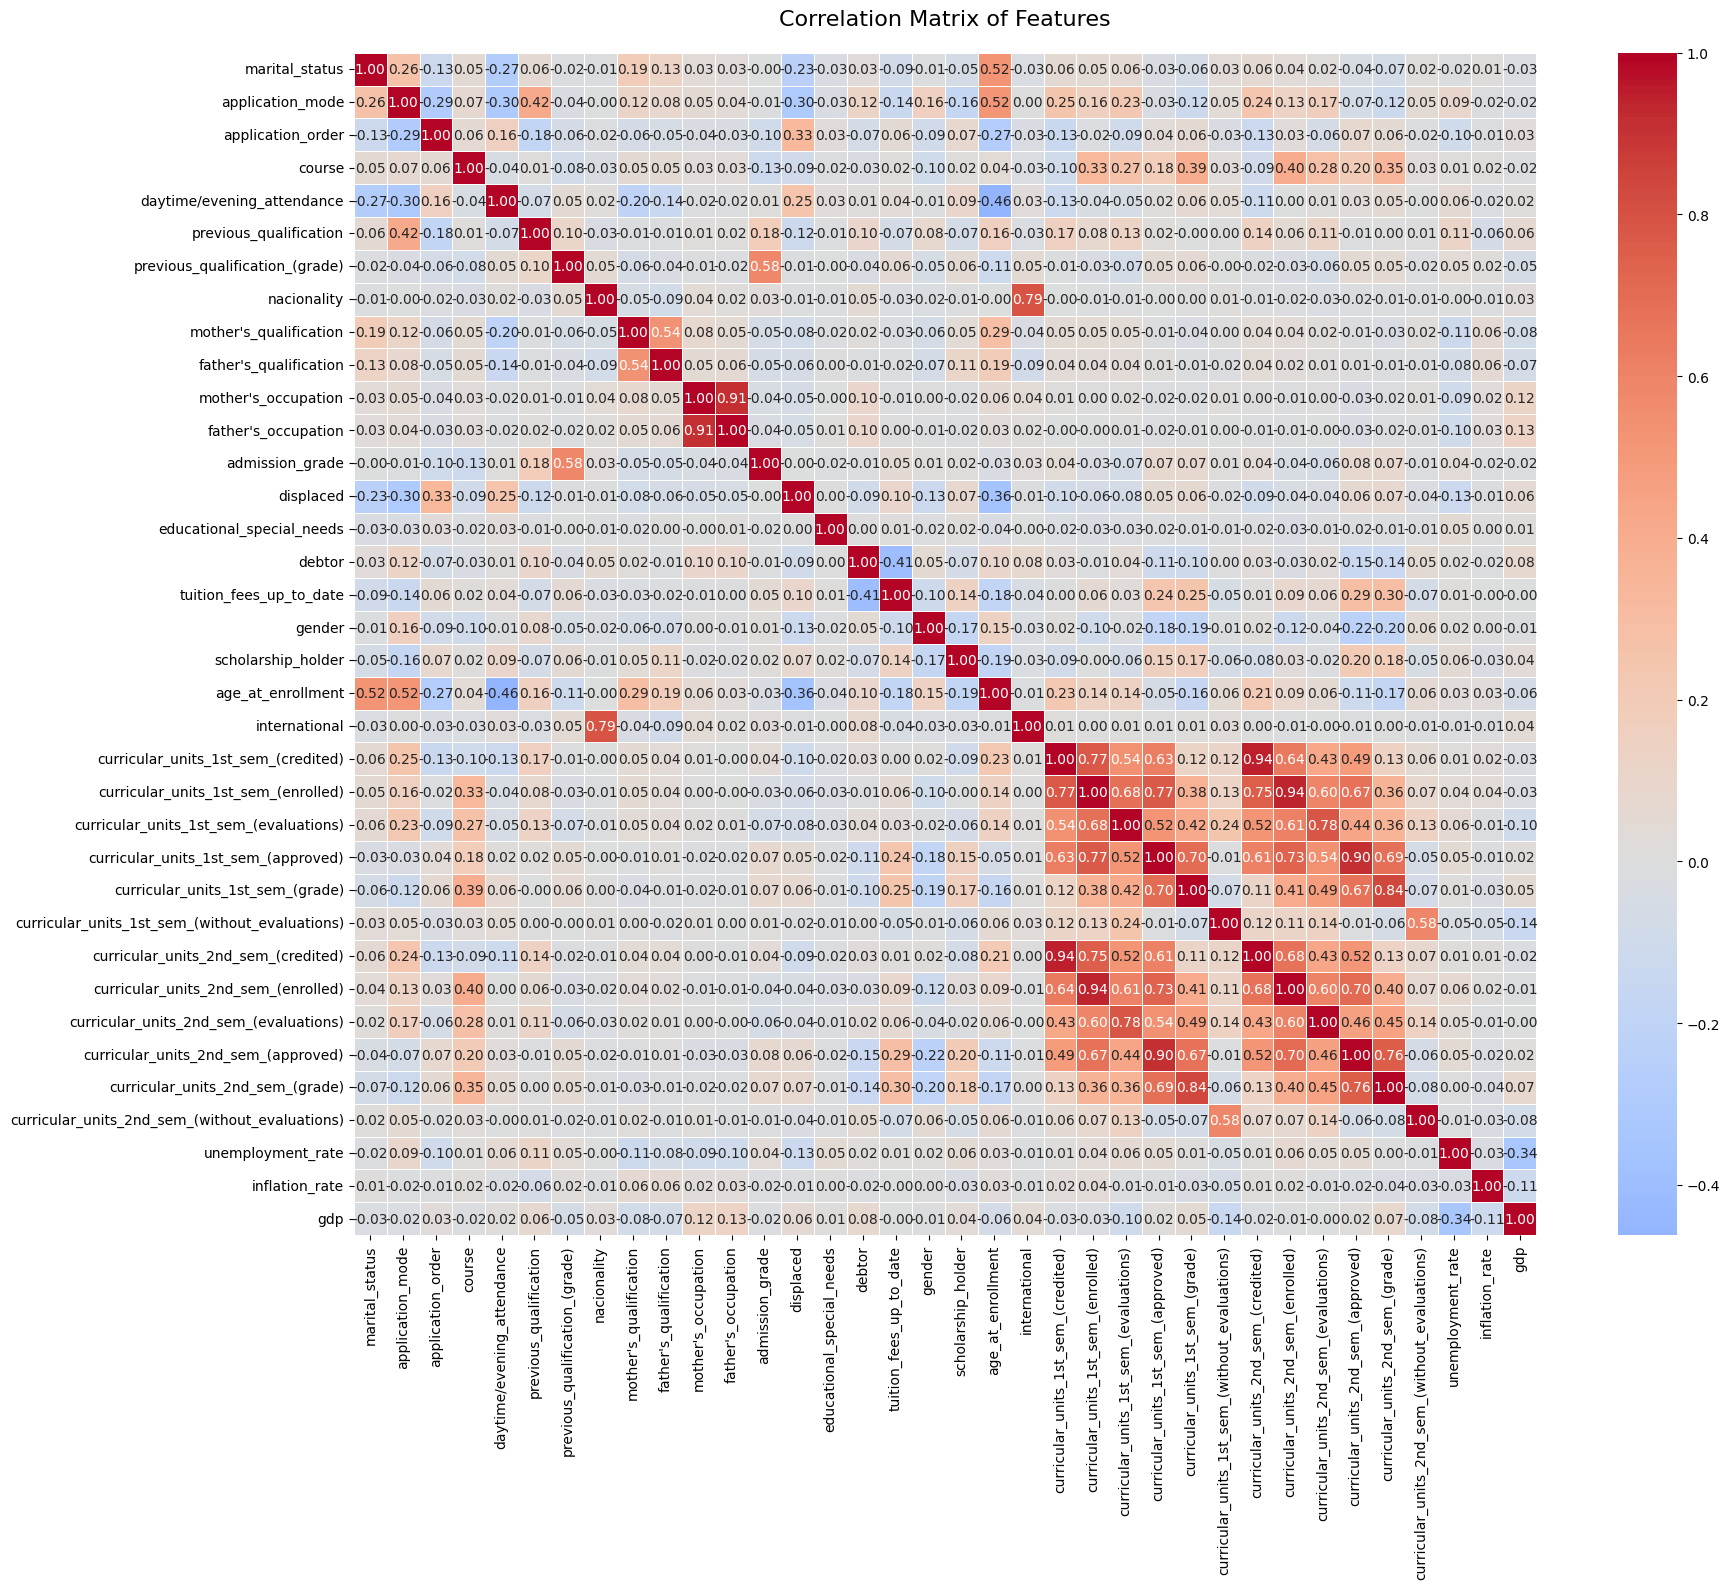


Feature pairs with correlation > 0.7: 26
curricular_units_1st_sem_(credited) -- curricular_units_2nd_sem_(credited): 0.945
curricular_units_2nd_sem_(credited) -- curricular_units_1st_sem_(credited): 0.945
curricular_units_1st_sem_(enrolled) -- curricular_units_2nd_sem_(enrolled): 0.943
curricular_units_2nd_sem_(enrolled) -- curricular_units_1st_sem_(enrolled): 0.943
mother's_occupation -- father's_occupation: 0.910
father's_occupation -- mother's_occupation: 0.910
curricular_units_1st_sem_(approved) -- curricular_units_2nd_sem_(approved): 0.904
curricular_units_2nd_sem_(approved) -- curricular_units_1st_sem_(approved): 0.904
curricular_units_1st_sem_(grade) -- curricular_units_2nd_sem_(grade): 0.837
curricular_units_2nd_sem_(grade) -- curricular_units_1st_sem_(grade): 0.837
nacionality -- international: 0.791
international -- nacionality: 0.791
curricular_units_1st_sem_(evaluations) -- curricular_units_2nd_sem_(evaluations): 0.779
curricular_units_2nd_sem_(evaluations) -- curricular_u

In [13]:
# Create correlation matrix
plt.figure(figsize=(20, 16))
correlation_matrix = features_df.corr()

# Create a heatmap
sns.heatmap(correlation_matrix, 
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Color scheme
            center=0,  # Center the colormap at 0
            fmt='.2f',  # Format correlation values to 2 decimal places
            square=True,  # Make the plot square-shaped
            linewidths=0.5)  # Add gridlines

plt.title('Correlation Matrix of Features', pad=20, size=16)
plt.tight_layout()
plt.show()

# Print the features with highest absolute correlations
threshold = 0.7  # You can adjust this threshold
high_corr = np.where(np.abs(correlation_matrix) > threshold)
high_corr = [(correlation_matrix.index[x], correlation_matrix.columns[y], correlation_matrix.iloc[x, y]) 
             for x, y in zip(*high_corr) if x != y]

print("\nFeature pairs with correlation > 0.7:", len(high_corr))
for feat1, feat2, corr in sorted(high_corr, key=lambda x: abs(x[2]), reverse=True):
    print(f"{feat1} -- {feat2}: {corr:.3f}")

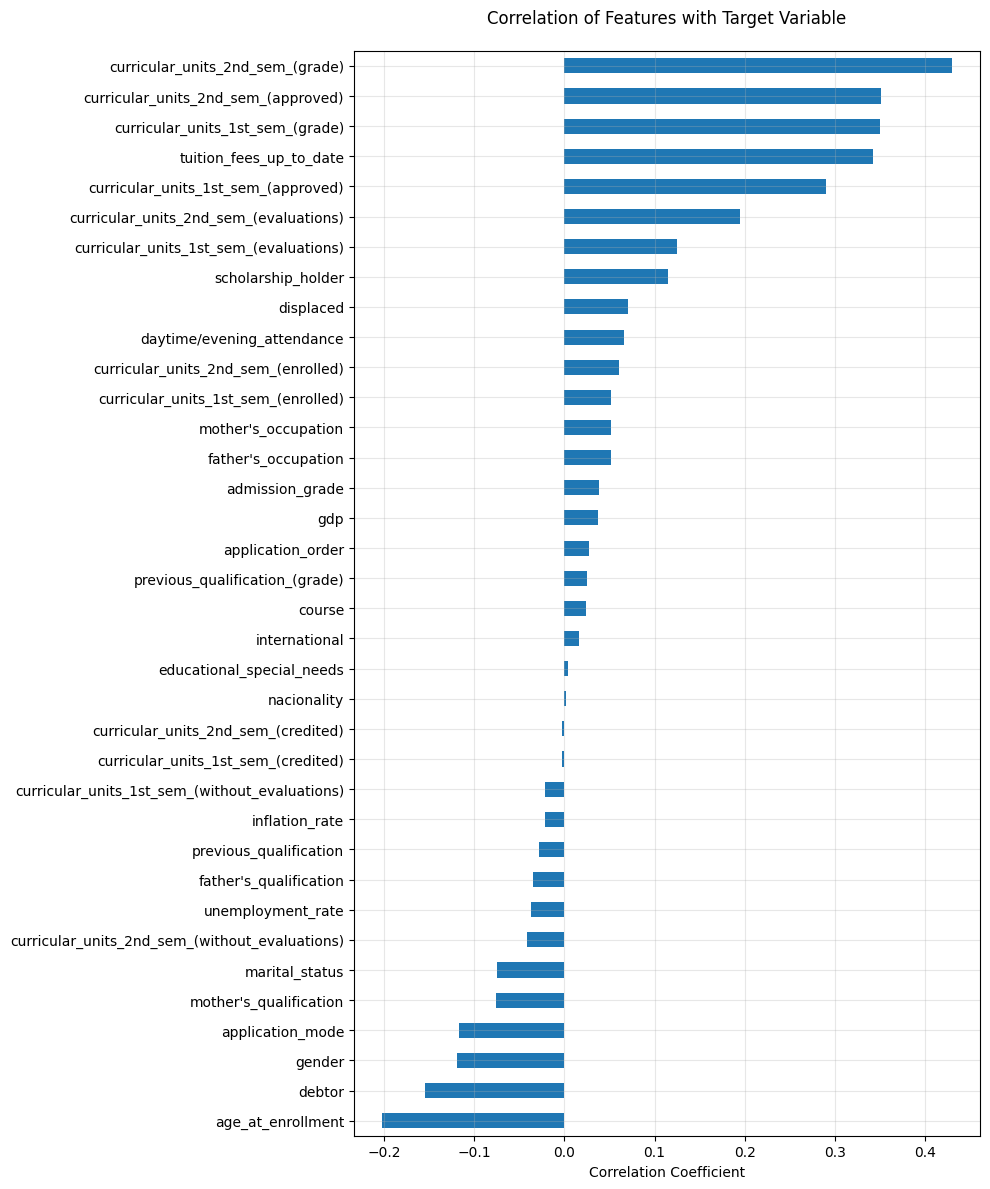


Feature correlations with target (sorted by absolute value):
curricular_units_2nd_sem_(grade): 0.429
curricular_units_2nd_sem_(approved): 0.351
curricular_units_1st_sem_(grade): 0.350
tuition_fees_up_to_date: 0.342
curricular_units_1st_sem_(approved): 0.290
age_at_enrollment: -0.202
curricular_units_2nd_sem_(evaluations): 0.194
debtor: -0.155
curricular_units_1st_sem_(evaluations): 0.125
gender: -0.118
application_mode: -0.117
scholarship_holder: 0.115
mother's_qualification: -0.076
marital_status: -0.074
displaced: 0.071
daytime/evening_attendance: 0.066
curricular_units_2nd_sem_(enrolled): 0.061
curricular_units_1st_sem_(enrolled): 0.052
mother's_occupation: 0.052
father's_occupation: 0.051
curricular_units_2nd_sem_(without_evaluations): -0.041
admission_grade: 0.039
unemployment_rate: -0.037
gdp: 0.037
father's_qualification: -0.035
previous_qualification: -0.028
application_order: 0.027
previous_qualification_(grade): 0.025
course: 0.024
inflation_rate: -0.022
curricular_units_1st

In [14]:
# Combine features and target into one dataframe
combined_df = pd.concat([features_df, target_df], axis=1)

# Calculate correlations with target
target_correlations = combined_df.corr()['target'].sort_values(ascending=True)  # Changed to True for better visualization

# Create a horizontal bar plot of correlations with target
plt.figure(figsize=(10, 12))  # Adjusted figure size for horizontal layout
target_correlations.drop('target').plot(kind='barh')  # Changed to 'barh' for horizontal bars
plt.title('Correlation of Features with Target Variable', pad=20)
plt.xlabel('Correlation Coefficient')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print correlations sorted by absolute value
print("\nFeature correlations with target (sorted by absolute value):")
abs_correlations = target_correlations.drop('target').abs().sort_values(ascending=False)
for feature in abs_correlations.index:
    print(f"{feature}: {target_correlations[feature]:.3f}")

We are combining the classes 1 and 2 in the target variable as we want to predict whether a student will drop out or not. The classes 1 (Enrolled) and 2 (Graduated) are too similar to each other, so we want to combine them into a single class.

In [15]:
# Combine the classes 1 and 2 in the target variable
target_df["target"] = target_df["target"].replace({2: 1})

### Applying one-hot encoding to the categorical columns

In [16]:
# One Hot Encoding the categorical columns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

one_hot_encoded_features = pd.get_dummies(features_df, columns=multi_class_columns)
one_hot_encoded_features = pd.get_dummies(one_hot_encoded_features, columns=ordinal_columns )
one_hot_encoded_features = pd.get_dummies(one_hot_encoded_features, columns=binary_columns)



In [17]:
# Print shape of the dataframe
print(one_hot_encoded_features.shape)

(4424, 262)


## Implementing Dimensionality Reduction techniques

### Principal Component Analysis

In [18]:
# Perform PCA
scaler = StandardScaler()
# scaler.fit(one_hot_encoded_features)

scaled_features = scaler.fit_transform(one_hot_encoded_features[numerical_columns])

pca = PCA(n_components='mle')
pca.fit(scaled_features)

# Transform the data
pca_features = pca.transform(scaled_features)

# Print the shape of the transformed data
print(pca_features.shape)

(4424, 17)


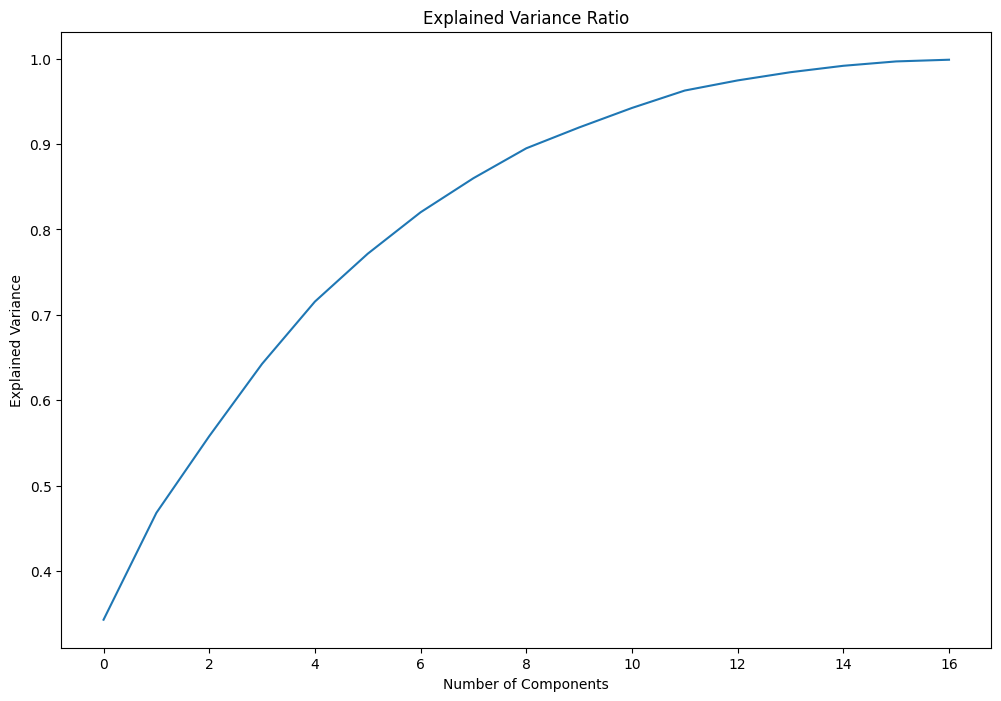

In [19]:
# Plot the explained variance ratio
plt.figure(figsize=(12, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance Ratio')
plt.show()


### t-SNE

(4424, 2)


Text(0.5, 1.0, 't-SNE Features')

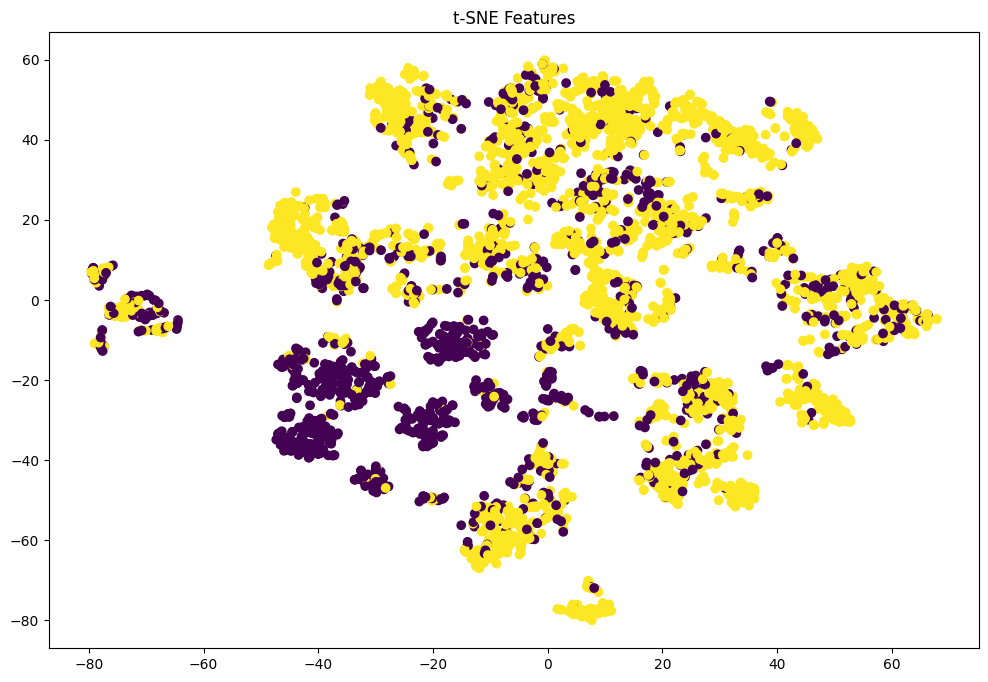

In [20]:
# Apply t-SNE to reduce the number of features
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(pca_features)

# Print the shape of the transformed data
print(tsne_features.shape)

# Plot the t-SNE features
plt.figure(figsize=(12, 8))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=target_df["target"], cmap='viridis')
plt.title('t-SNE Features')



- The scatter plot shows the relationship between the t-SNE features and the target variable.
- The color of the points represents the target variable.

## Implementing Classification Models

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(pca_features, target_df, test_size=0.2, random_state=42)

### XGBoost Classifier

In [23]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize the XGBoost classifier
xgboost_model = xgb.XGBClassifier(random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)

# Train the model with the best parameters
best_xgboost_model = xgb.XGBClassifier(**best_params, random_state=42)
best_xgboost_model.fit(X_train, y_train)
y_pred = best_xgboost_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
Best Cross-Validation Accuracy: 0.8564572195718363
Accuracy: 0.8361581920903954
              precision    recall  f1-score   support

           0       0.83      0.68      0.75       316
           1       0.84      0.92      0.88       569

    accuracy                           0.84       885
   macro avg       0.83      0.80      0.81       885
weighted avg       0.84      0.84      0.83       885

[[215 101]
 [ 44 525]]


The best cross validation accuracy is **0.85**.

- The `xgboost` library is used to train the model.
- The `GridSearchCV` is used to find the best hyperparameters for the model.
- The best hyperparameters are used to train the model.
- The model is then evaluated on the test set.


### Naive Bayes Classifier

In [24]:
# Import necessary libraries
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pca_features, target_df.values.ravel(), test_size=0.2, random_state=42)

# Create a GaussianNB classifier
nb = GaussianNB()

# Define the parameter grid for GridSearchCV
# For GaussianNB, we can tune var_smoothing parameter
param_grid = {
    'var_smoothing': np.logspace(-10, -1, 10)
}

# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=nb,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on test set
y_pred = best_model.predict(X_test)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Calculate and print accuracy score
accuracy = best_model.score(X_test, y_test)
print(f"\nTest Set Accuracy: {accuracy:.4f}")

Best parameters: {'var_smoothing': np.float64(0.01)}
Best cross-validation score: 0.8030506077242107

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.62      0.67       316
           1       0.81      0.88      0.84       569

    accuracy                           0.78       885
   macro avg       0.77      0.75      0.76       885
weighted avg       0.78      0.78      0.78       885


Confusion Matrix:
[[196 120]
 [ 71 498]]

Test Set Accuracy: 0.7842


The best cross-validation score is **0.80**.

- The `GaussianNB` library is used to train the model.
- The `GridSearchCV` is used to find the best hyperparameters for the model.
- The best hyperparameters are used to train the model.
- The model is then evaluated on the test set.
- The test set accuracy is **0.78**.

### Neural Network

/Users/gibranmyageri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch 1/50


/Users/gibranmyageri/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6812 - loss: 0.7039 - val_accuracy: 0.8263 - val_loss: 0.4241
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8193 - loss: 0.4511 - val_accuracy: 0.8291 - val_loss: 0.4015
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8288 - loss: 0.4041 - val_accuracy: 0.8460 - val_loss: 0.3704
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8456 - loss: 0.3594 - val_accuracy: 0.8489 - val_loss: 0.3573
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8529 - loss: 0.3596 - val_accuracy: 0.8573 - val_loss: 0.3603
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8359 - loss: 0.3700 - val_accuracy: 0.8531 - val_loss: 0.3590
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8382 - loss: 0.3820 - val_accuracy: 0.8559 - val_loss: 0.3526
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8521 - loss: 0.3559 - val_accuracy: 0.8545 - val_loss: 0.3509
Epo

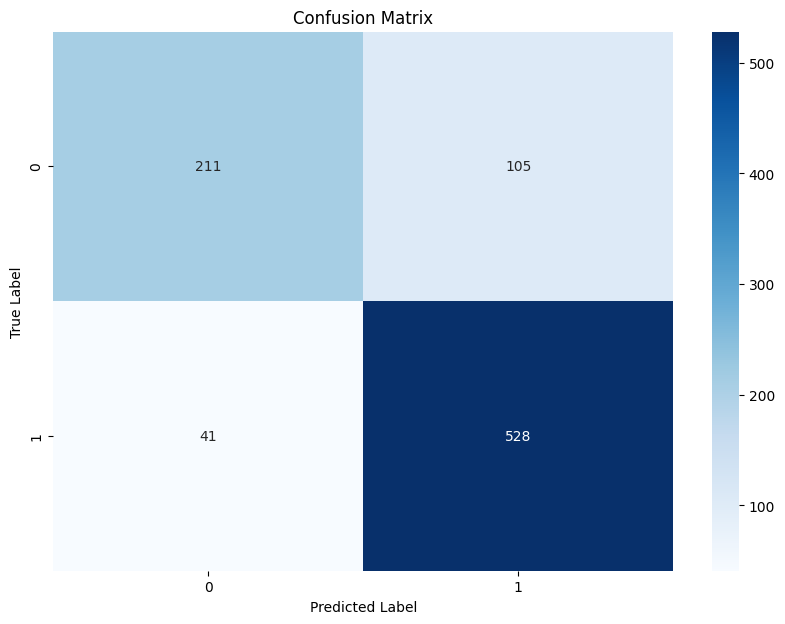

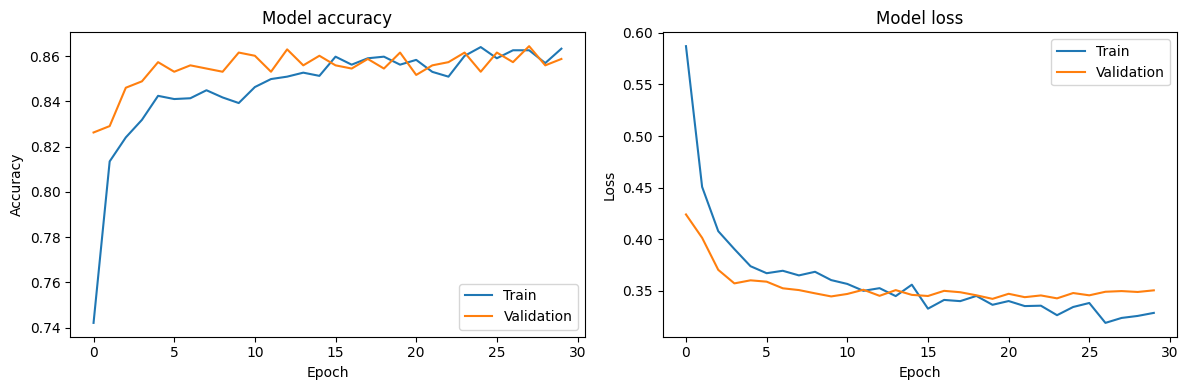

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Convert target to one-hot encoded format using OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(target_df.values.reshape(-1, 1))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(pca_features, y_encoded, test_size=0.2, random_state=42)

# Create the model
model = Sequential([
    # Input layer
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    
    # Hidden layer 1
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    # Hidden layer 2
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    
    # Output layer
    Dense(y_encoded.shape[1], activation='softmax')  # Number of classes from encoded y
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print classification report
print('\nClassification Report:')
print(classification_report(y_test_classes, y_pred_classes))

# Create and plot confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

The accuracy obtained is **0.84**.

- The `tf.keras` library is used to train the model.
- The neural network has one input layer with 128 units, 2 hidden layers with 64, and 32 units respectively.
- The `EarlyStopping` callback is used to prevent overfitting.
- The model is trained on the training set and evaluated on the test set. 

### Decision Tree Classifier

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.64      0.72       316
           1       0.82      0.93      0.87       569

    accuracy                           0.82       885
   macro avg       0.83      0.78      0.80       885
weighted avg       0.83      0.82      0.82       885



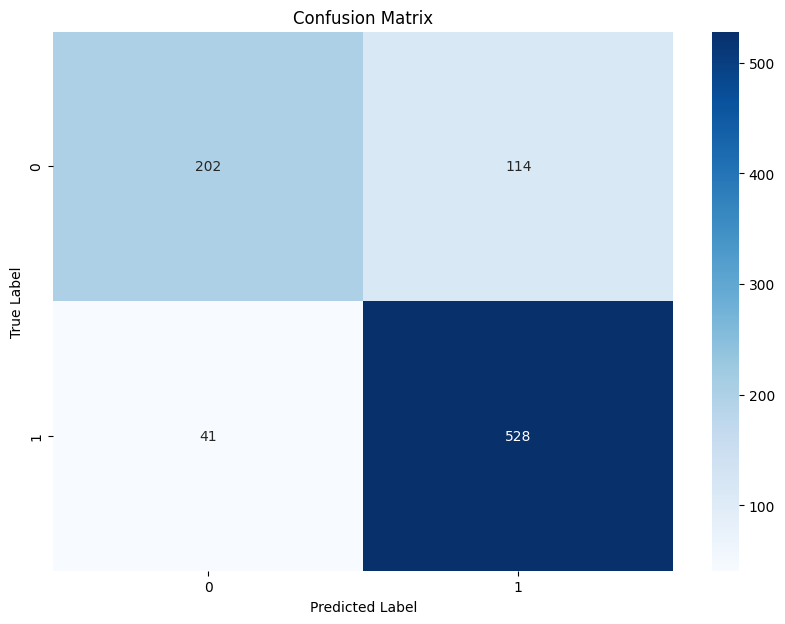

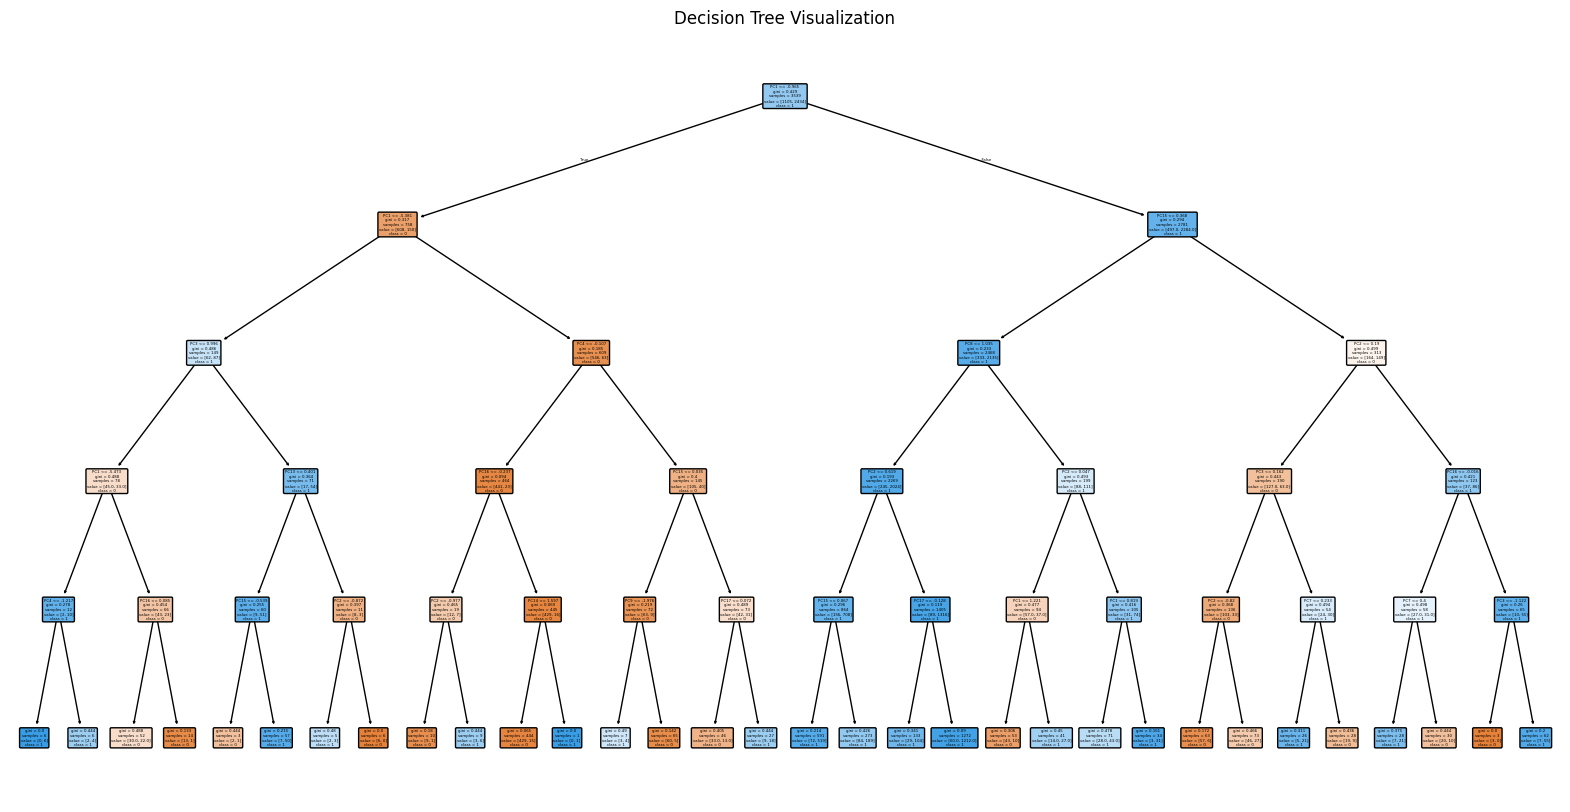


Accuracy Score: 0.8249


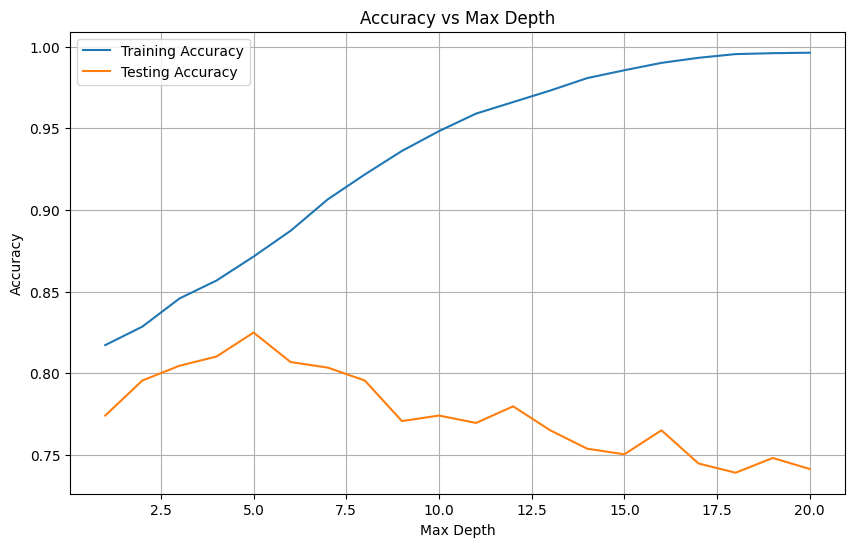

In [29]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Split the data (using original target, not one-hot encoded)
X_train, X_test, y_train, y_test = train_test_split(pca_features, target_df.values.ravel(), 
                                                    test_size=0.2, random_state=42)

# Create and train the decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=5)  # Limiting depth for better visualization
dt.fit(X_train, y_train)

# Make predictions
y_pred = dt.predict(X_test)

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Visualize the decision tree
plt.figure(figsize=(20,10))
plot_tree(dt, feature_names=[f'PC{i+1}' for i in range(X_train.shape[1])], 
          class_names=np.unique(y_train).astype(str), 
          filled=True, rounded=True)
plt.title('Decision Tree Visualization')
plt.show()

# Print the accuracy score
print(f'\nAccuracy Score: {dt.score(X_test, y_test):.4f}')

# If you want to try different max_depths to find optimal depth
depths = range(1, 21)
train_scores = []
test_scores = []

for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    train_scores.append(dt.score(X_train, y_train))
    test_scores.append(dt.score(X_test, y_test))

# Plot accuracy vs depth
plt.figure(figsize=(10, 6))
plt.plot(depths, train_scores, label='Training Accuracy')
plt.plot(depths, test_scores, label='Testing Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth')
plt.legend()
plt.grid(True)
plt.show()

The accuracy obtained is **0.82**.

- The `DecisionTreeClassifier` is used to train the model.
- The max depth is set to 5.
- The model is trained on the training set and evaluated on the test set.
- The decision tree is visualized using the `plot_tree` function.
- As the max depth is increased, the training accuracy increases, but the test accuracy decreases.

### Logistic Regression

Accuracy: 0.8361581920903954
              precision    recall  f1-score   support

           0       0.84      0.67      0.74       316
           1       0.83      0.93      0.88       569

    accuracy                           0.84       885
   macro avg       0.84      0.80      0.81       885
weighted avg       0.84      0.84      0.83       885



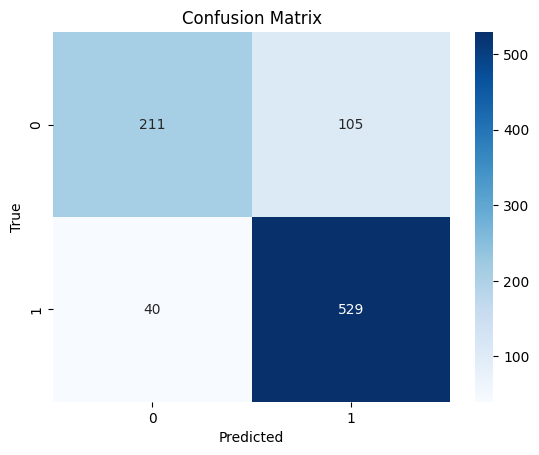

In [34]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression classifier
lr_model = LogisticRegression(random_state=42, max_iter=10000)

# Train the model
lr_model.fit(X_train, y_train)

# Predict the target variable
y_pred = lr_model.predict(X_test)

# Print the accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

The accuracy obtained is **0.83**.

- The `LogisticRegression` library is used to train the model.
- The model is trained on the training set and evaluated on the test set.
- The confusion matrix is plotted.

### Random Forest Classifier

In [35]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=5)

# Train the model
rf_model.fit(X_train, y_train)

# Predict the target variable
y_pred = rf_model.predict(X_test)

# Print the accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.823728813559322
              precision    recall  f1-score   support

           0       0.86      0.60      0.71       316
           1       0.81      0.95      0.87       569

    accuracy                           0.82       885
   macro avg       0.84      0.77      0.79       885
weighted avg       0.83      0.82      0.81       885



The accuracy obtained is **0.82**.

- The `RandomForestClassifier` library is used to train the model.
- The max depth is set to 5.
- The model is trained on the training set and evaluated on the test set.

### SVM Classifier

In [36]:
# Apply SVM to the dataset
from sklearn.svm import SVC

# Initialize the SVM classifier
svm_model = SVC(random_state=42, kernel='rbf', C=1.0)

# Train the model
svm_model.fit(X_train, y_train)

# Predict the target variable
y_pred = svm_model.predict(X_test)

# Print the accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



Accuracy: 0.8406779661016949
              precision    recall  f1-score   support

           0       0.89      0.64      0.74       316
           1       0.83      0.95      0.89       569

    accuracy                           0.84       885
   macro avg       0.86      0.80      0.81       885
weighted avg       0.85      0.84      0.83       885



## Conclusion

The best model is the XGBoost classifier with an accuracy of **0.85**.